In [13]:
import numpy as np
import numpy.typing as npt
import math
import matplotlib.pyplot as plt 
from examples.seismic import Receiver, WaveletSource, RickerSource, Model, TimeAxis,  plot_velocity, plot_shotrecord
from devito import TimeFunction, Eq, solve, Operator, ConditionalDimension
from scipy.signal import find_peaks, peak_prominences, correlate

plt.rcParams['figure.figsize'] = (10, 10)

### Model Parameters

In [14]:
nx = 601
nz = 301
nb = 10
shape = (nx, nz)
spacing = (.0001, .0001) #60x30 cm
origin = (0., 0.)
v_water = 1.5 # v in distilled water 1496.7 m/s
v_glass = 5.64 # v in glass 5640 m/s
glass = 5
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = v_water 
v[:, -glass:] = v_glass
v[:glass, :] = v_glass
v[-glass:, :] = v_glass

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nb, bcs="damp")

# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = .02  # Simulation lasts tn milliseconds
dt = model.critical_dt # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


In [15]:
class SineSource(WaveletSource):
    @property
    def wavelet(self):
        t0 = self.t0 or 1 / self.f0
        a = self.a or 1
        r = (np.pi * self.f0 * (self.time_values - t0))
        wave = a * np.sin(r) + a*np.sin(3*(r+np.pi)/4)
        wave[np.searchsorted(self.time_values, 4*2/self.f0):] = 0
        return wave

def srcPositions(cx: float, cy:float, alpha:float, ns:int, sdist:float) -> np.typing.NDArray:
    assert alpha >= 0 and alpha < 180
    assert ns > 0
    dx = sdist * math.sin(math.pi / 180 * alpha)
    dy = sdist * math.cos(math.pi / 180 * alpha)

    res = np.zeros((ns, 2))
    res[:, 0] = np.linspace(cx - dx * (ns - 1) / 2, cx + dx * (ns - 1) / 2, num = ns)
    res[:, 1] = np.linspace(cy - dy * (ns - 1) / 2, cy + dy * (ns - 1) / 2, num = ns)
    return res


def setup_beam(src, rec, u, source_distance, center_pos, alpha, dt, c):
    ns = src.coordinates.data.shape[0]
    for i in range(ns):
        src.coordinates.data[i, :] = np.array(
            center_pos[0] + (i - (ns - 1) / 2) * source_distance
        )
    src.coordinates.data[:, -1] = center_pos[1]
#    rec.coordinates.data[:] = src.coordinates.data[:]
    for i in range(ns):
        latency = -np.cos(np.deg2rad(alpha)) * (i * source_distance / c)
        src.data[:, i] = np.roll(src.data[:, i], int(latency / dt) + 300)
    u.data.fill(0)

In [16]:
f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 10; # number of sources
nr = 10; # number of receivers
depth = .0005
wavelength = v_water / f0
source_distance = wavelength

### Point source and ideal signal

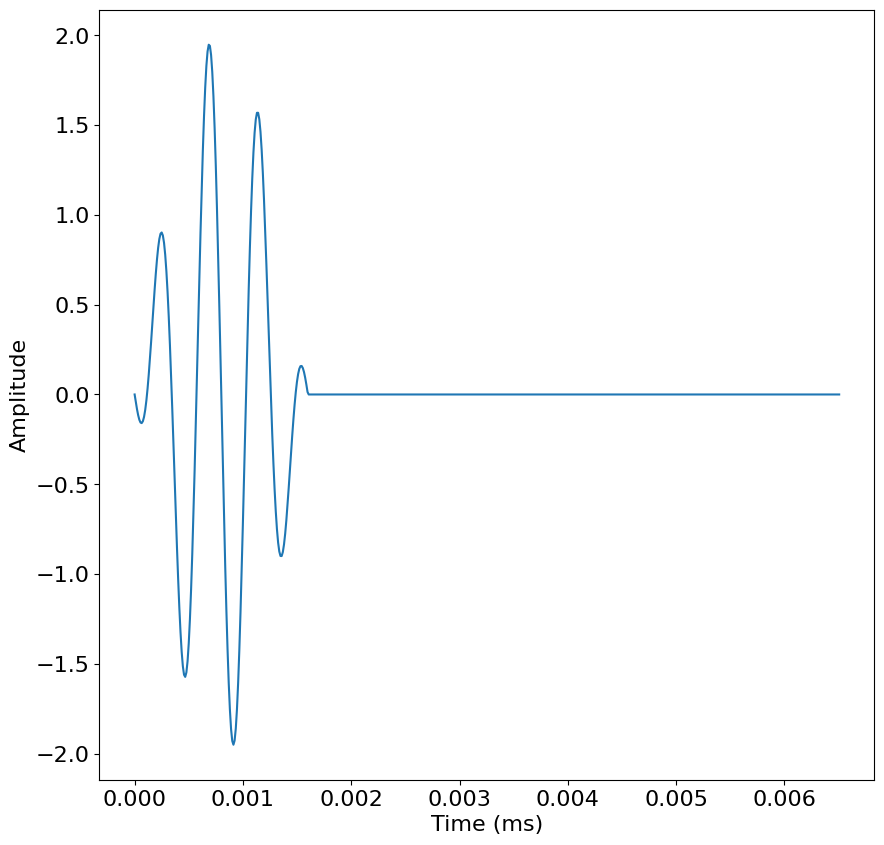

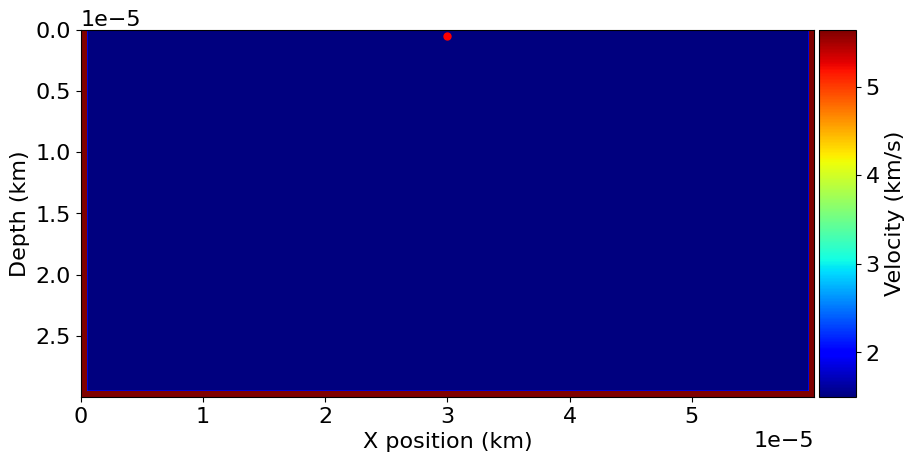

In [17]:
src = SineSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = .0005  # Depth is 20m
rec = Receiver(name='rec', grid=model.grid, npoint=1, time_range=time_range)
rec.coordinates.data[0, :] = np.array(model.domain_size) * .5
rec.coordinates.data[0, -1] = .0005  # Depth is 20m
plt.figure()
plt.plot(src.time_values[0:600], src.data[:600,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

plot_velocity(model, source=src.coordinates.data)

Operator `Kernel` ran in 0.57 s


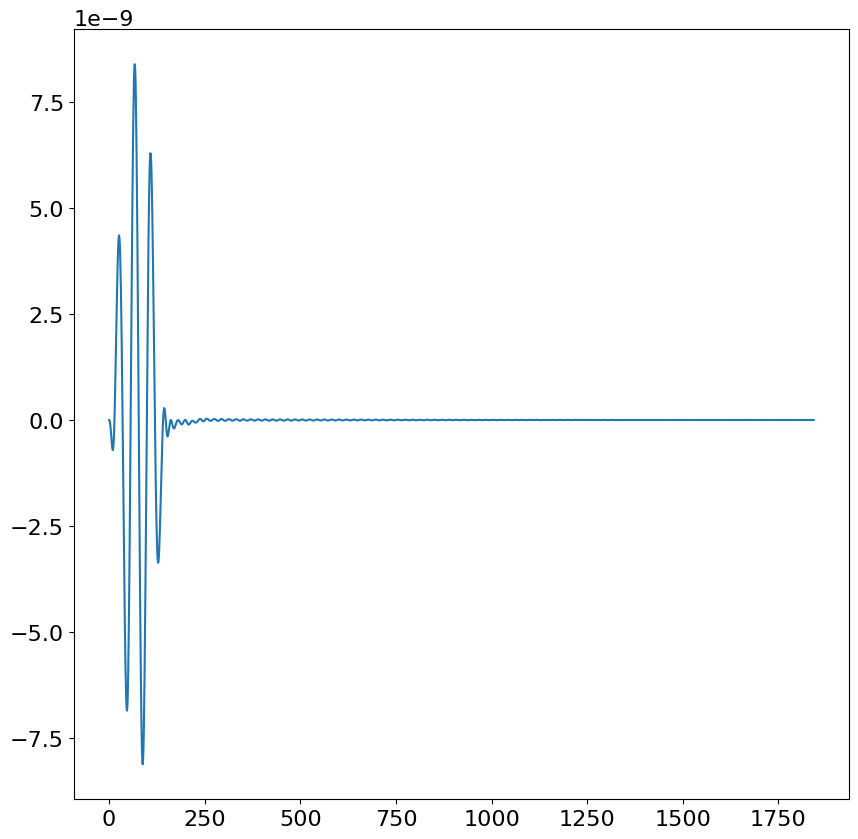

In [22]:
u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
op(time=nt - 2, dt=model.critical_dt)
# get the ideal signal
ideal_signal = rec.data[:,0]
plt.plot(ideal_signal)

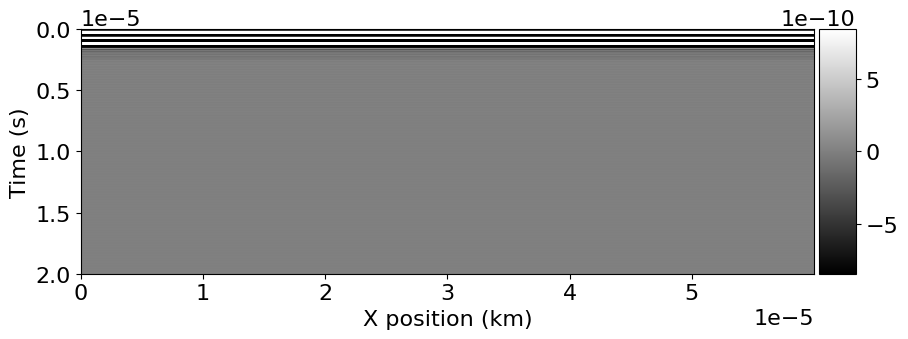

In [23]:
plot_shotrecord(rec.data, model, t0, tn, dt)

### Multi-point source and ideal signal

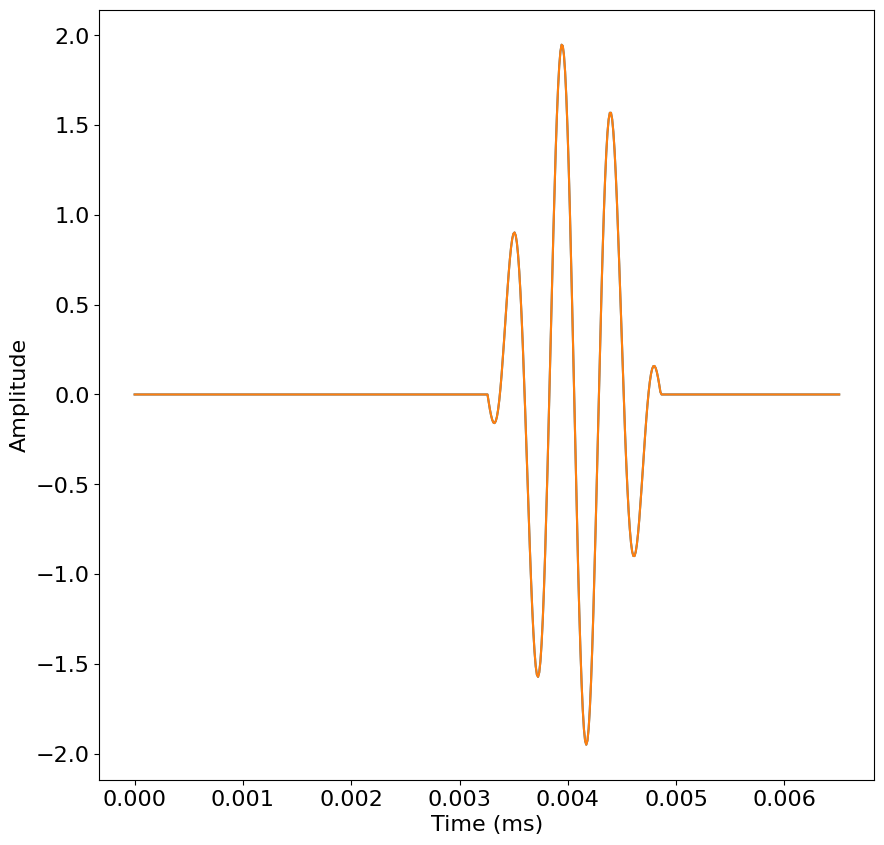

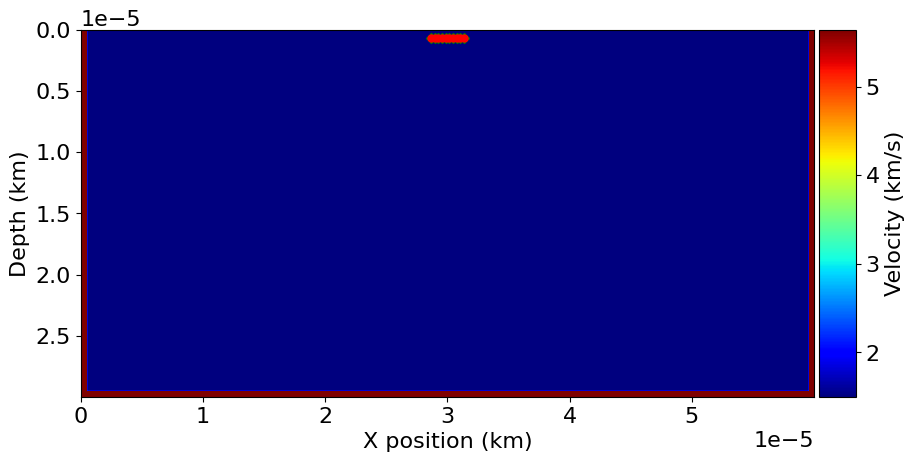

In [24]:
alpha = 90
src = SineSource(name='src', grid=model.grid, f0=f0,
                 npoint=ns, time_range=time_range)
rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range)
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
center_pos = np.array((cx,cy))
setup_beam(src, rec, u, source_distance, center_pos, alpha, model.critical_dt, v_water)
rec.coordinates.data[:] = src.coordinates.data[:]
plt.figure()
plt.plot(src.time_values[0:600], src.data[:600,0])
plt.plot(src.time_values[0:600], src.data[:600,9])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()
plot_velocity(model,source=src.coordinates.data, receiver=rec.coordinates.data)

In [25]:
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)
op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
op(time=nt - 2, dt=model.critical_dt)

Operator `Kernel` ran in 0.52 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.5026939999999992, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0035499999999999343, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.002718999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

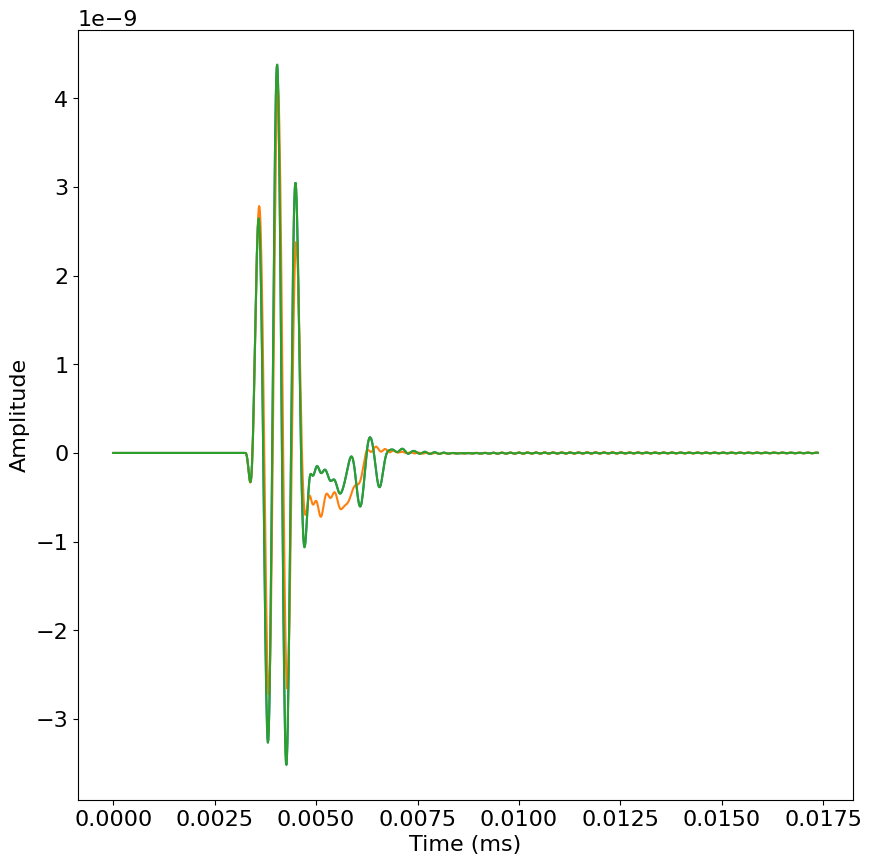

In [26]:
cut = 1600

plt.figure()
plt.plot(src.time_values[:cut],rec.data[:cut,0])
plt.plot(src.time_values[:cut],rec.data[:cut,4])
plt.plot(src.time_values[:cut],rec.data[:cut,9])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

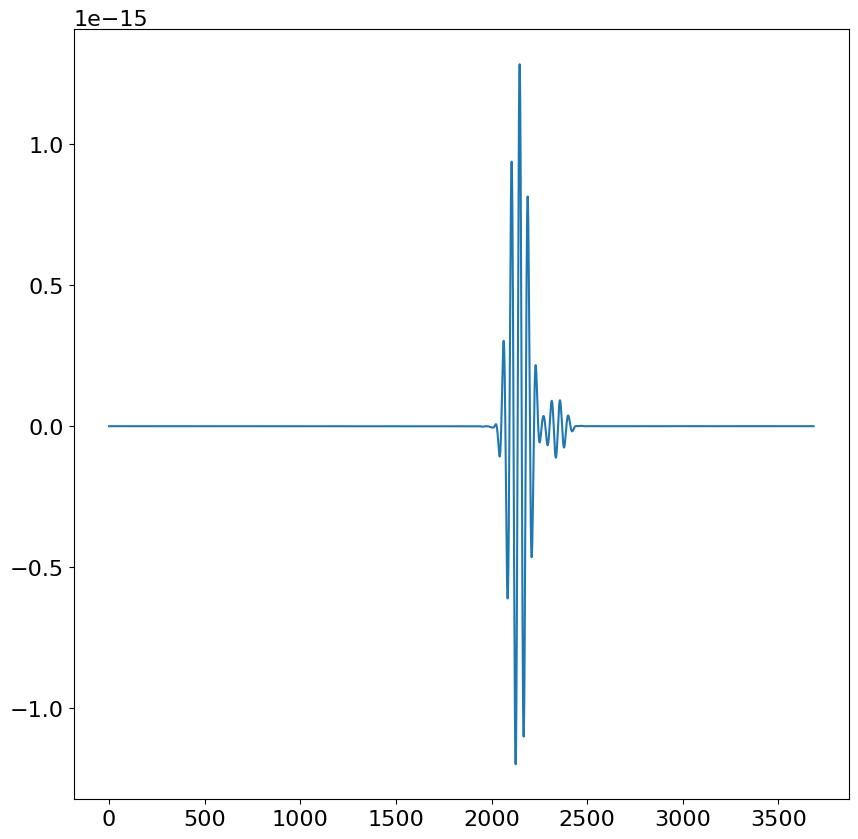

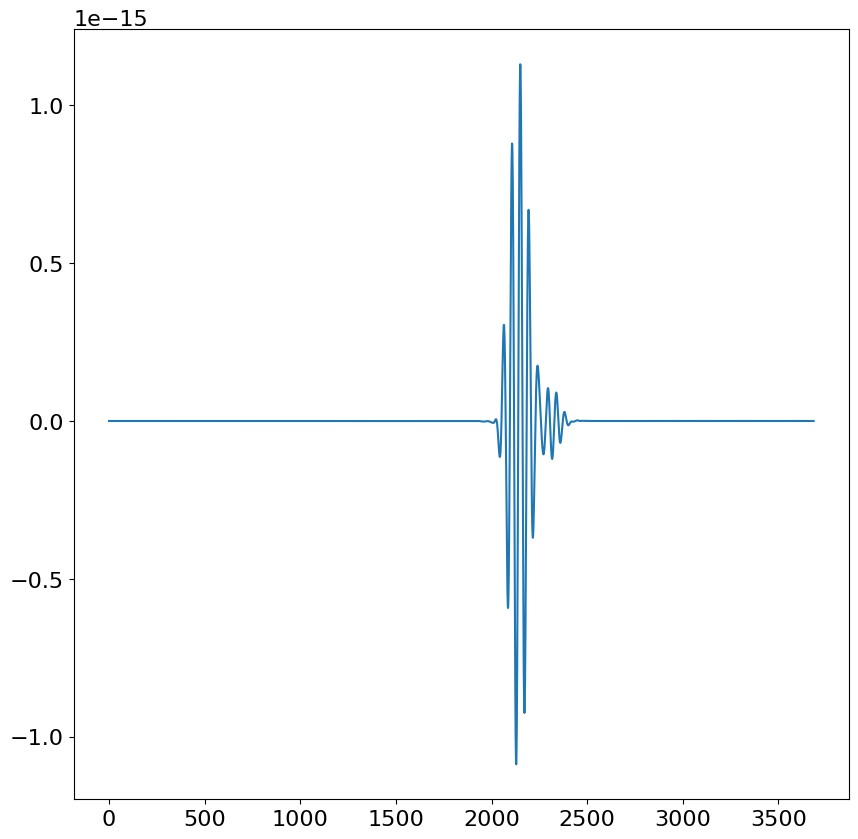

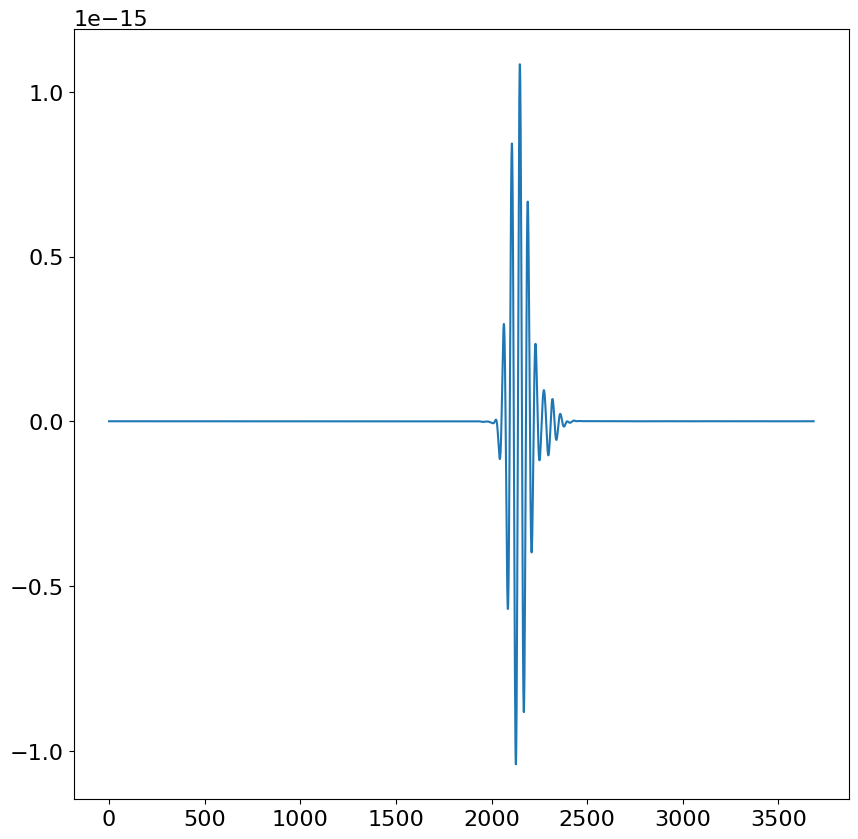

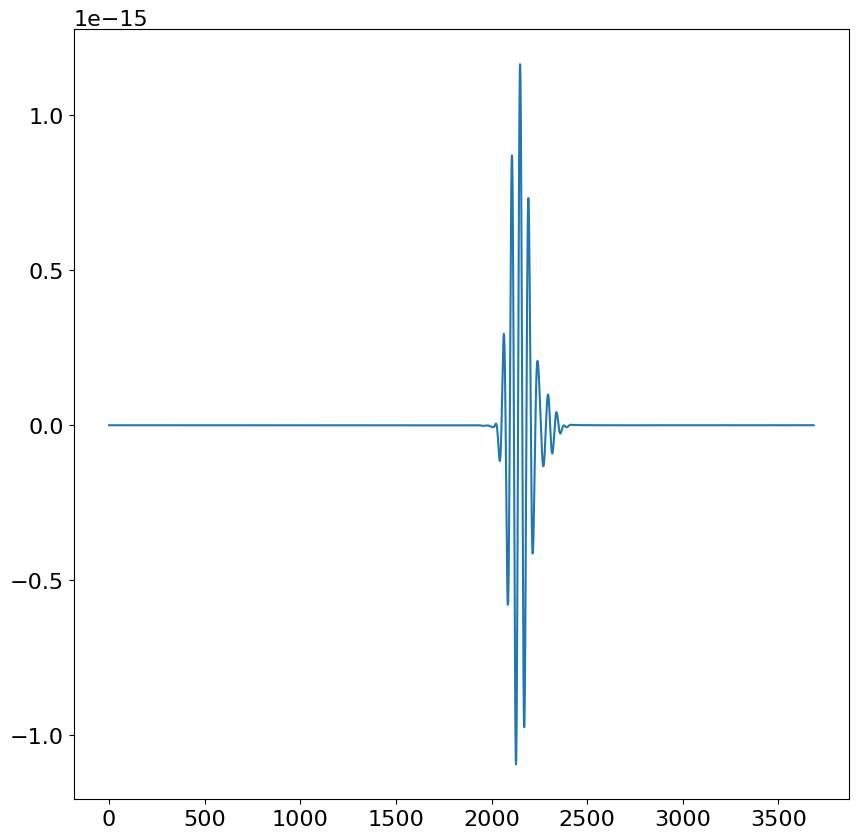

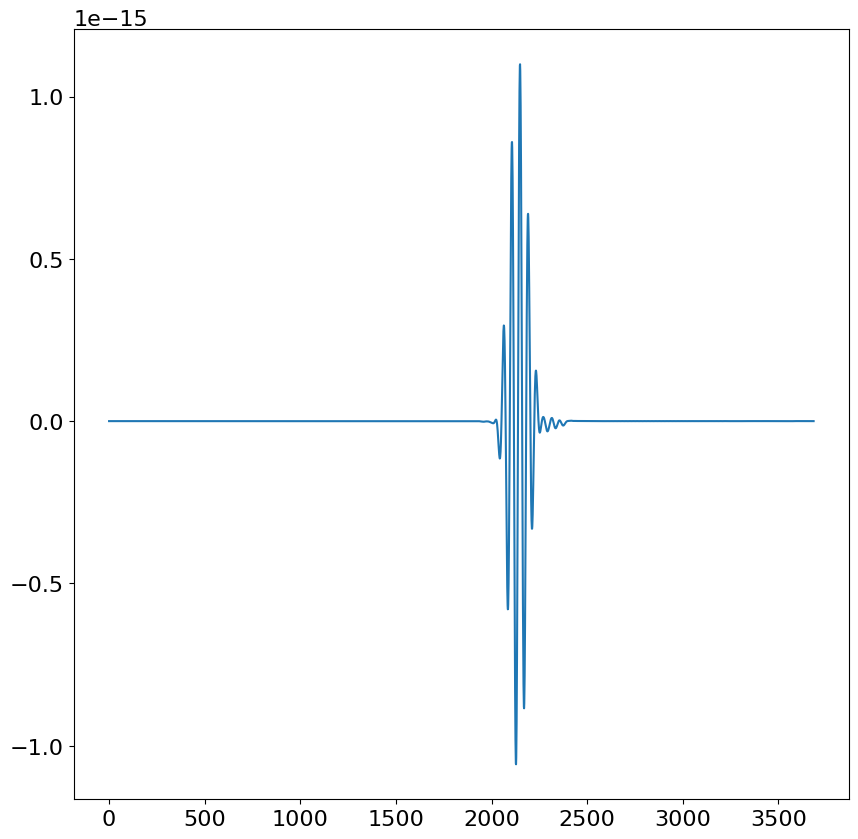

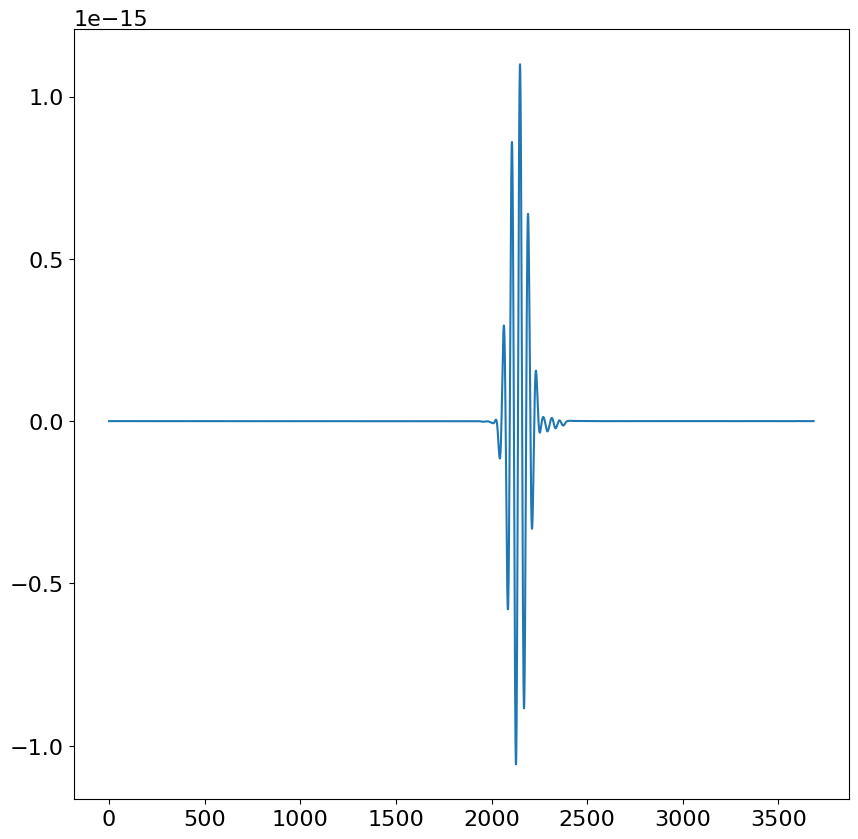

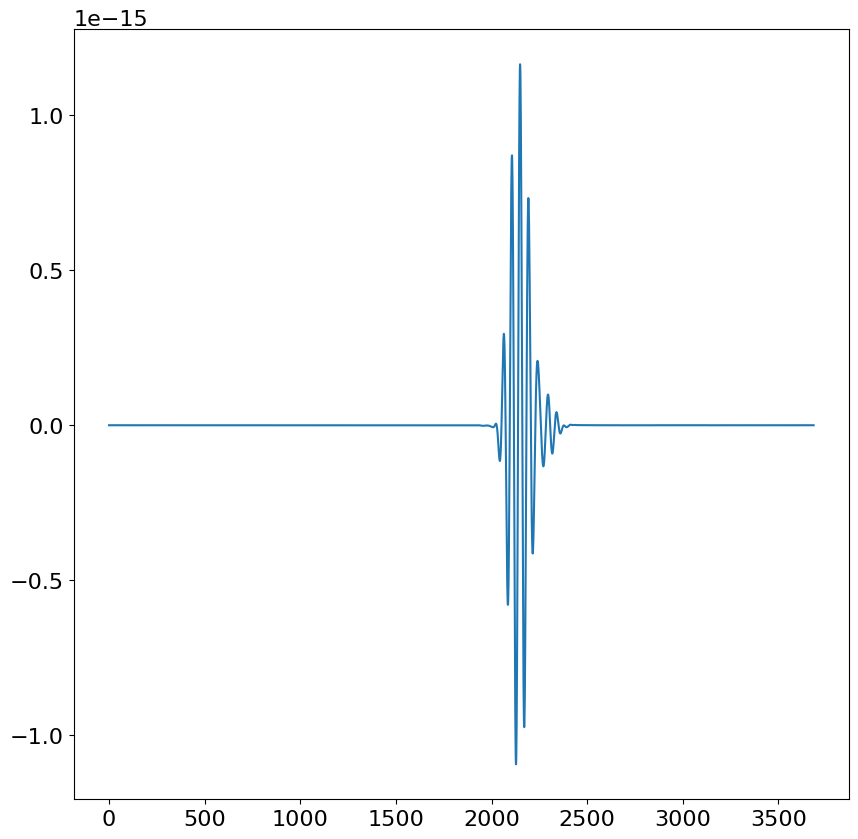

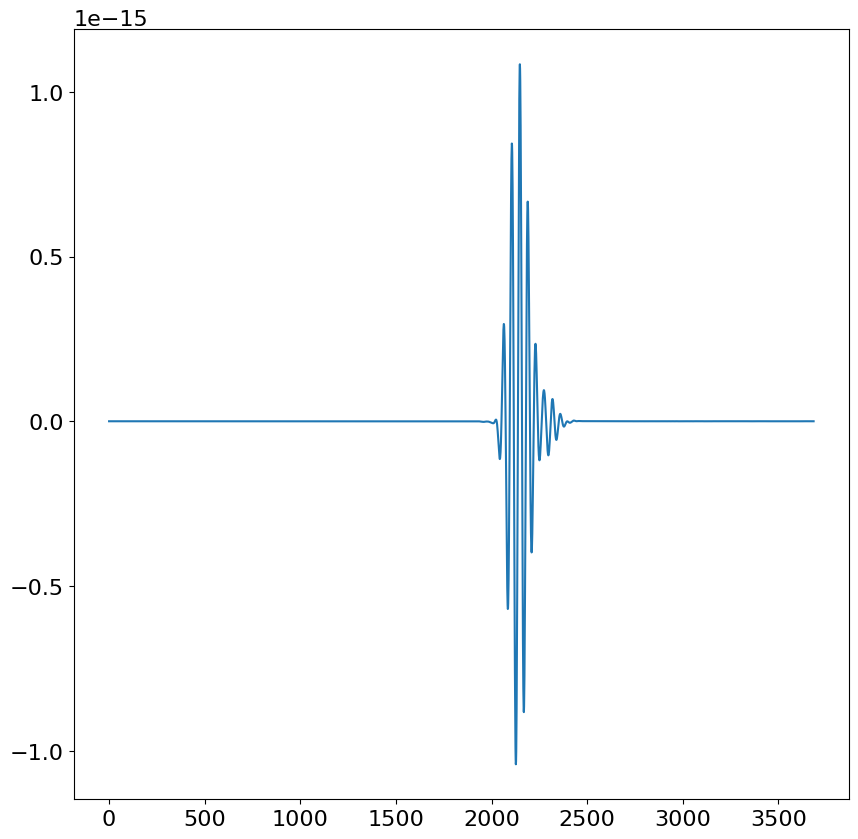

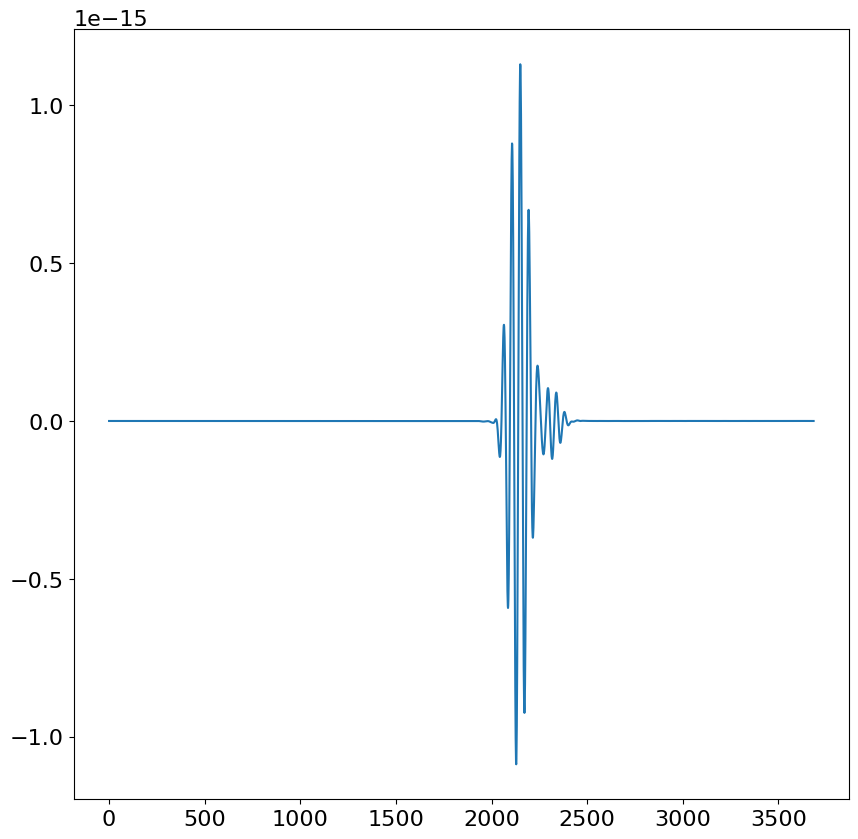

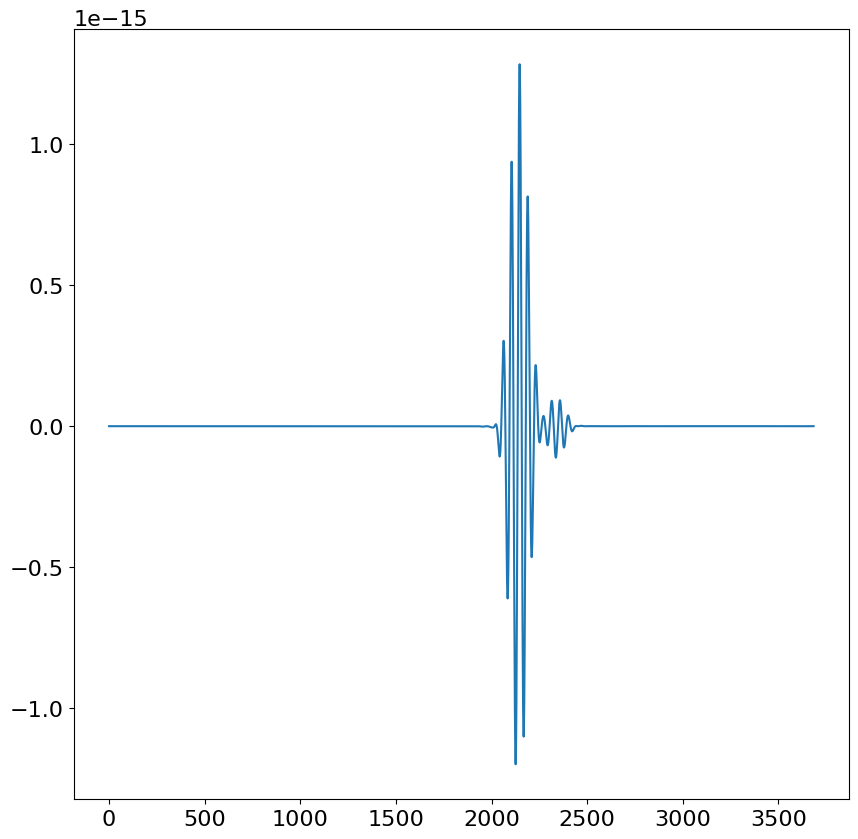

In [28]:
corr = np.zeros((ns, u.shape[0] * 2 - 1))
for i in range(ns):
    corr[i, :] = correlate(rec.data[:, i], ideal_signal, mode='full')
    plt.figure()
    plt.plot(corr[i, :])
    plt.show()

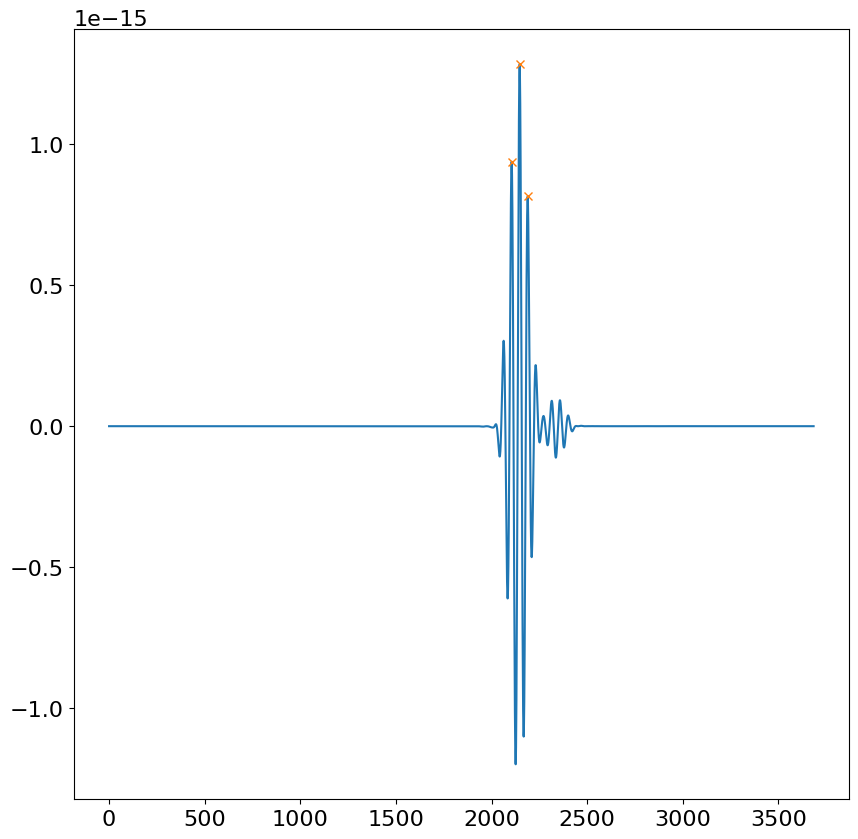

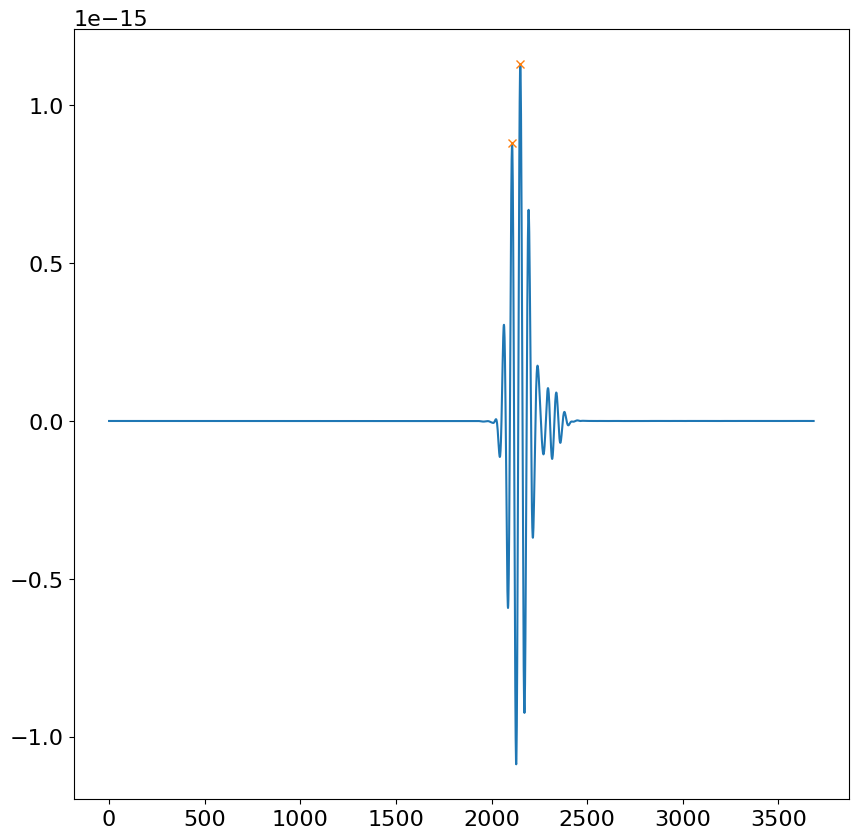

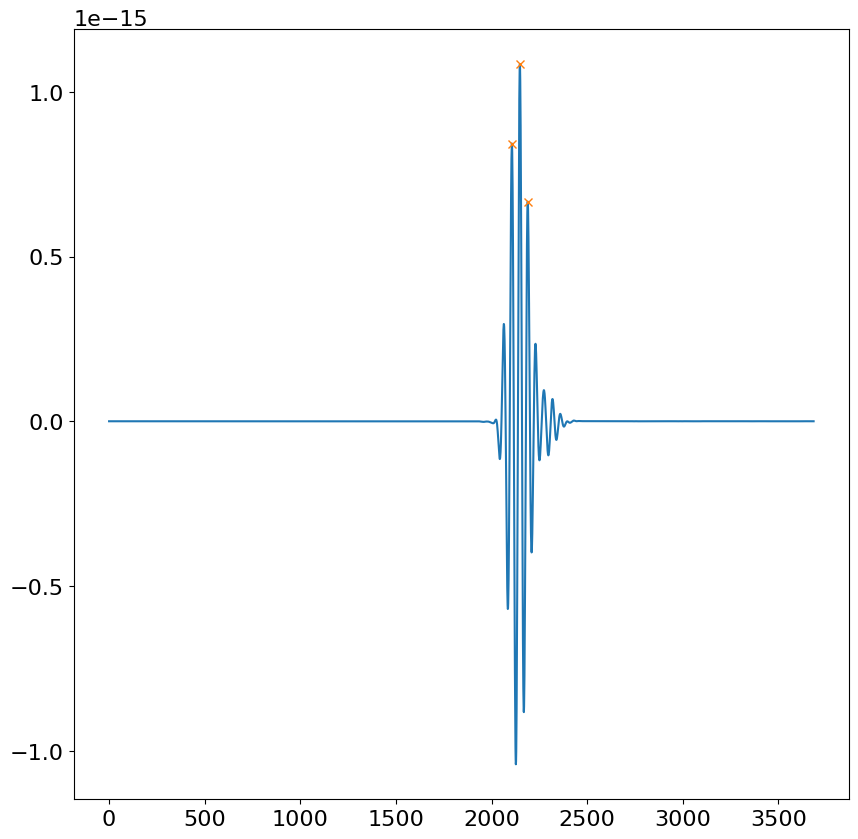

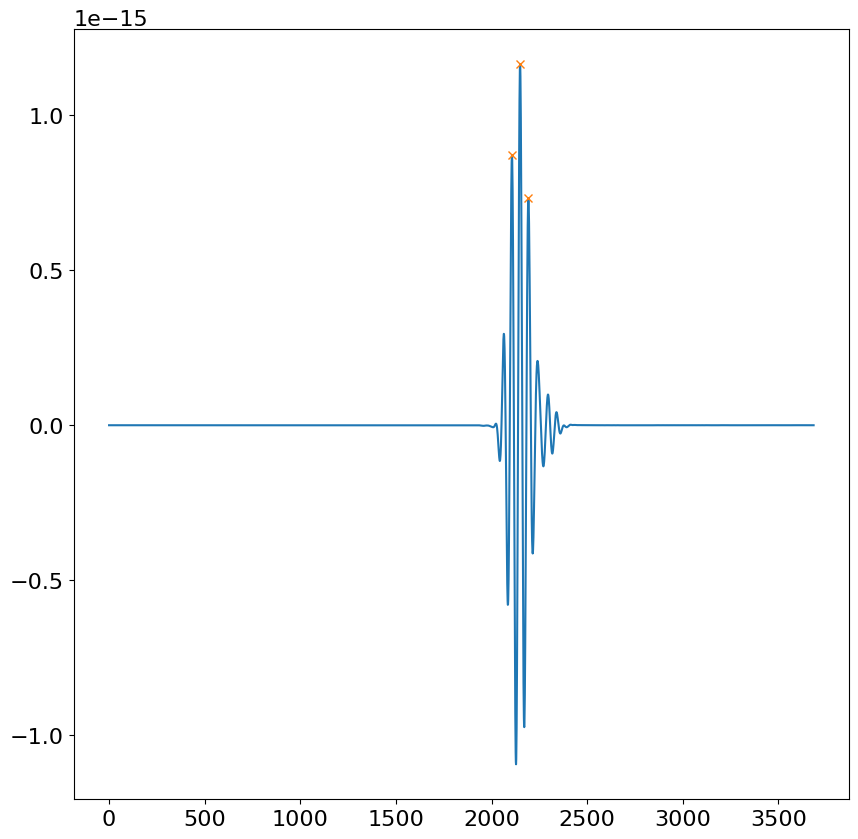

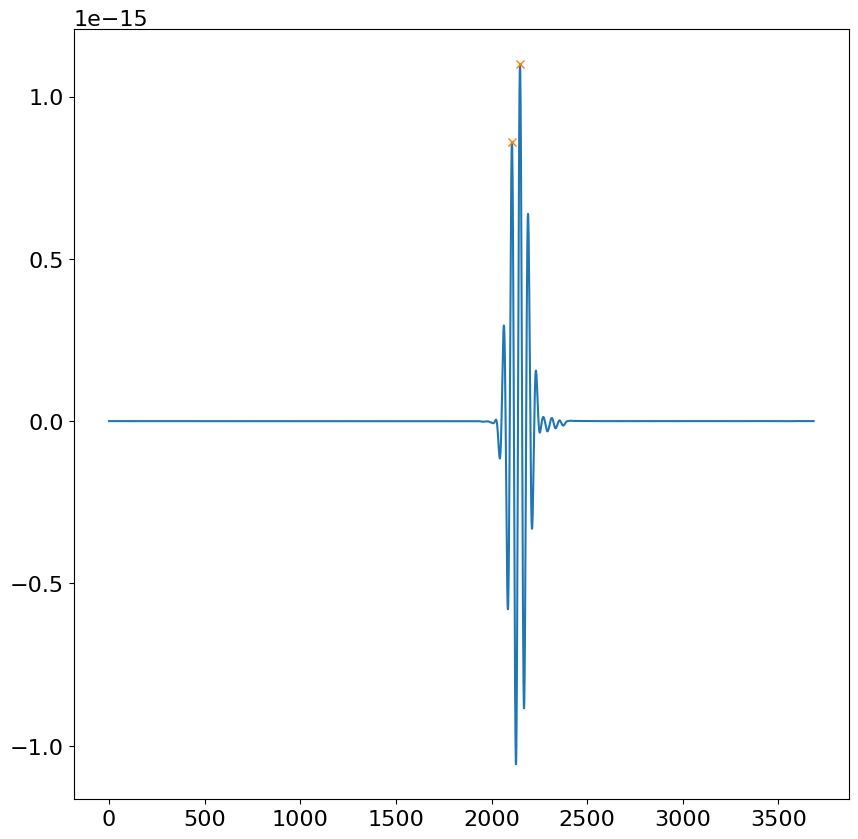

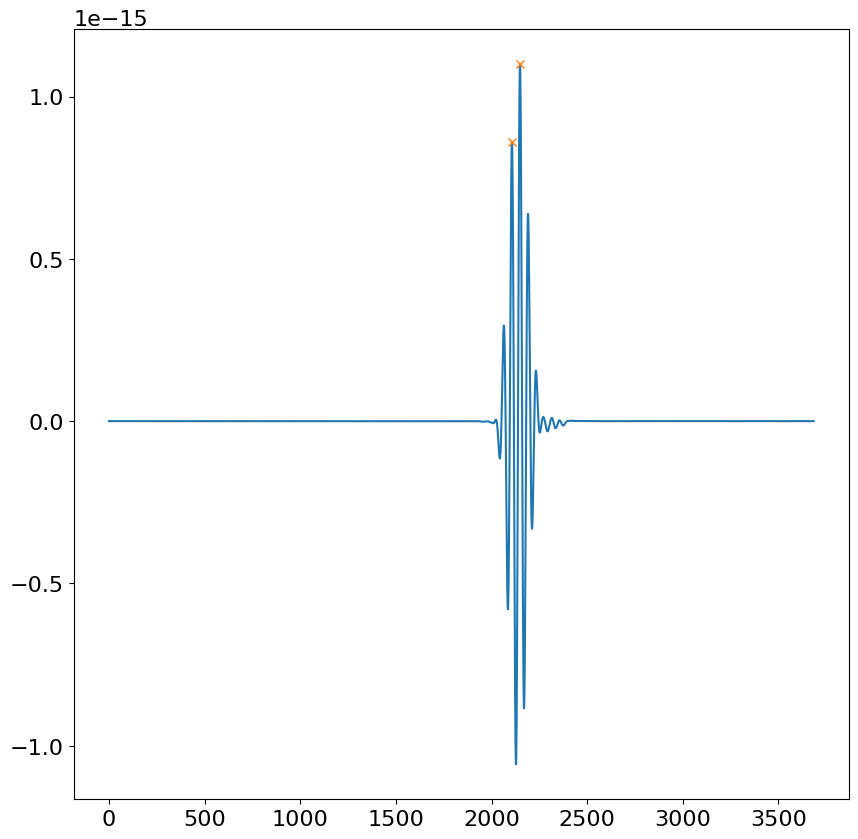

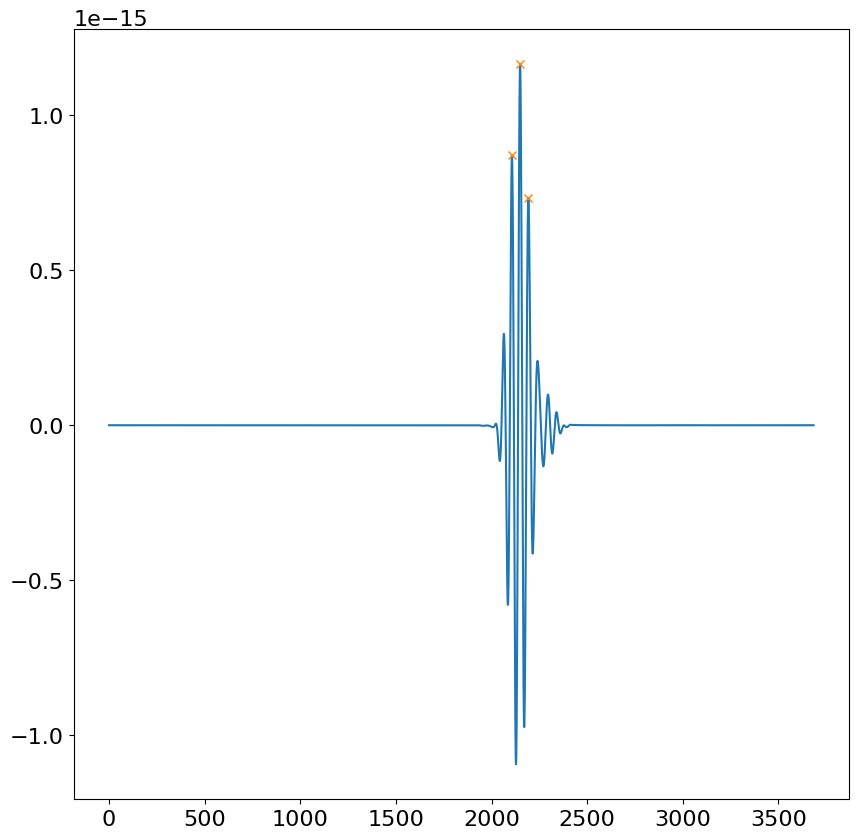

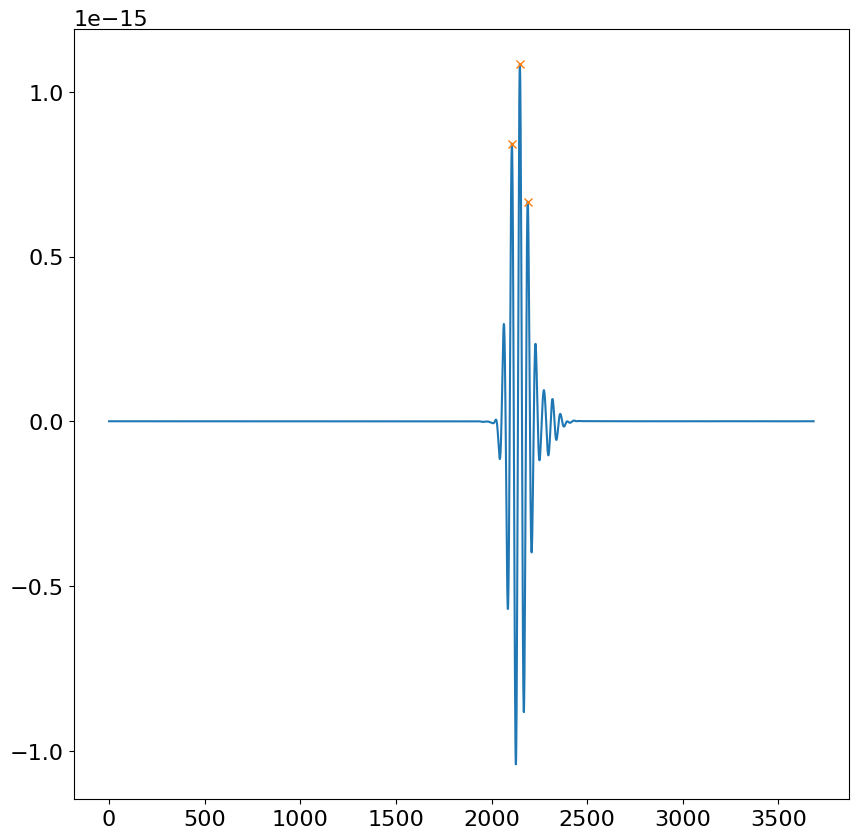

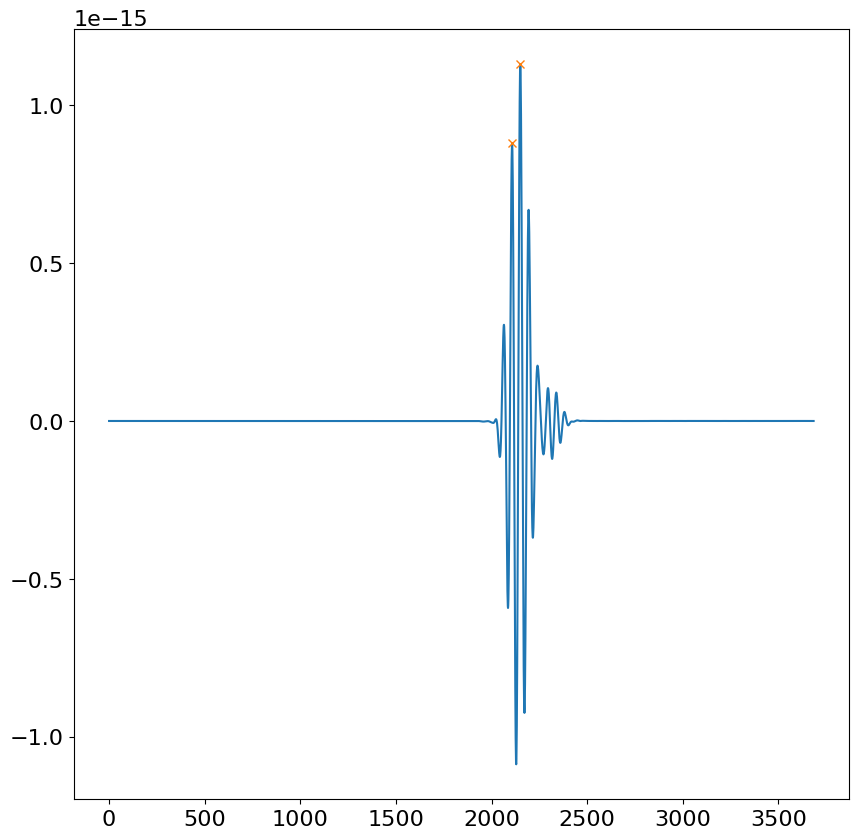

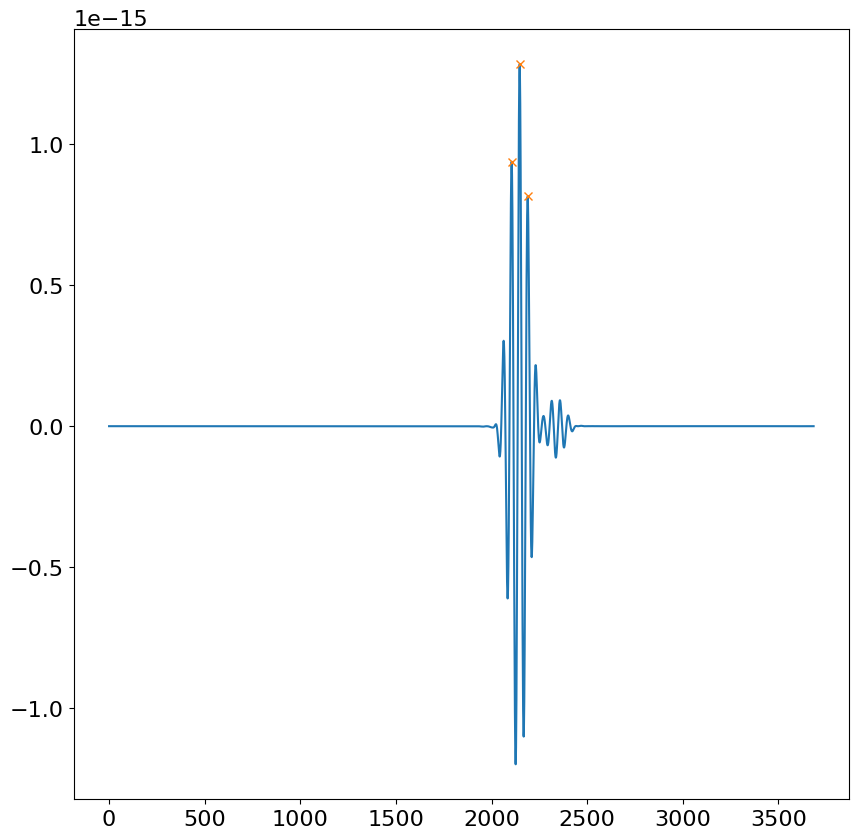

In [29]:
peak_indices = np.zeros(ns, dtype=np.int32)
for i in range(ns):
    peaks, _ = find_peaks(corr[i, :], height=np.max(corr[i, :]) * 0.6, distance=10)
    if(len(peaks) > 0):
        peak_indices[i] = peaks[0]
    else:
        peak_indices[i] = -1
    plt.figure()
    plt.plot(corr[i, :])
    plt.plot(peaks, corr[i, peaks], "x")
    plt.show()

In [30]:
distances = np.zeros(ns)
for i in range(ns):
    if peak_indices[i] > 0:
        distances[i] = dt * (peak_indices[i] - u.shape[0])
    else:
        distances[i] = np.nan
        
print(distances)

[0.00284532 0.00286704 0.00285618 0.00286704 0.00286704 0.00286704
 0.00286704 0.00285618 0.00286704 0.00284532]
